In [ ]:
from pandas.core.arrays import period
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta

# Define the ticker symbol
ticker_symbol = "QQQ"

# Define the interval
interval = "1h"

#
period = "730d"

print(f"Downloading {ticker_symbol} data with {period} period...")

# Download the data
df_qqq = yf.download(ticker_symbol, period="730d", interval=interval)

# Save the file
df_qqq.to_csv('QQQ_1h.csv')

# Display the first 5 rows of the DataFrame
display(df_qqq.head(10))

/tmp/ipython-input-3227172702.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_qqq = yf.download(ticker_symbol, period="730d", interval=interval)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,QQQ,QQQ,QQQ,QQQ,QQQ
Datetime,,,,,
2023-02-27 14:30:00+00:00,295.690002,296.489990,294.470001,295.070007,12671957
2023-02-27 15:30:00+00:00,294.190002,295.719910,293.779999,295.690002,8096330
2023-02-27 16:30:00+00:00,294.170013,294.519989,293.510010,294.200012,6401183
2023-02-27 17:30:00+00:00,294.798004,295.170013,294.140015,294.190002,3570174
2023-02-27 18:30:00+00:00,294.820007,295.420013,294.230011,294.820007,4743542


/tmp/ipython-input-512542646.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=plot_labels, y=avg_vol, ax=axes[0], palette="mako")
/tmp/ipython-input-512542646.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=plot_labels, y=win_rate, ax=axes[1], palette="RdYlGn")


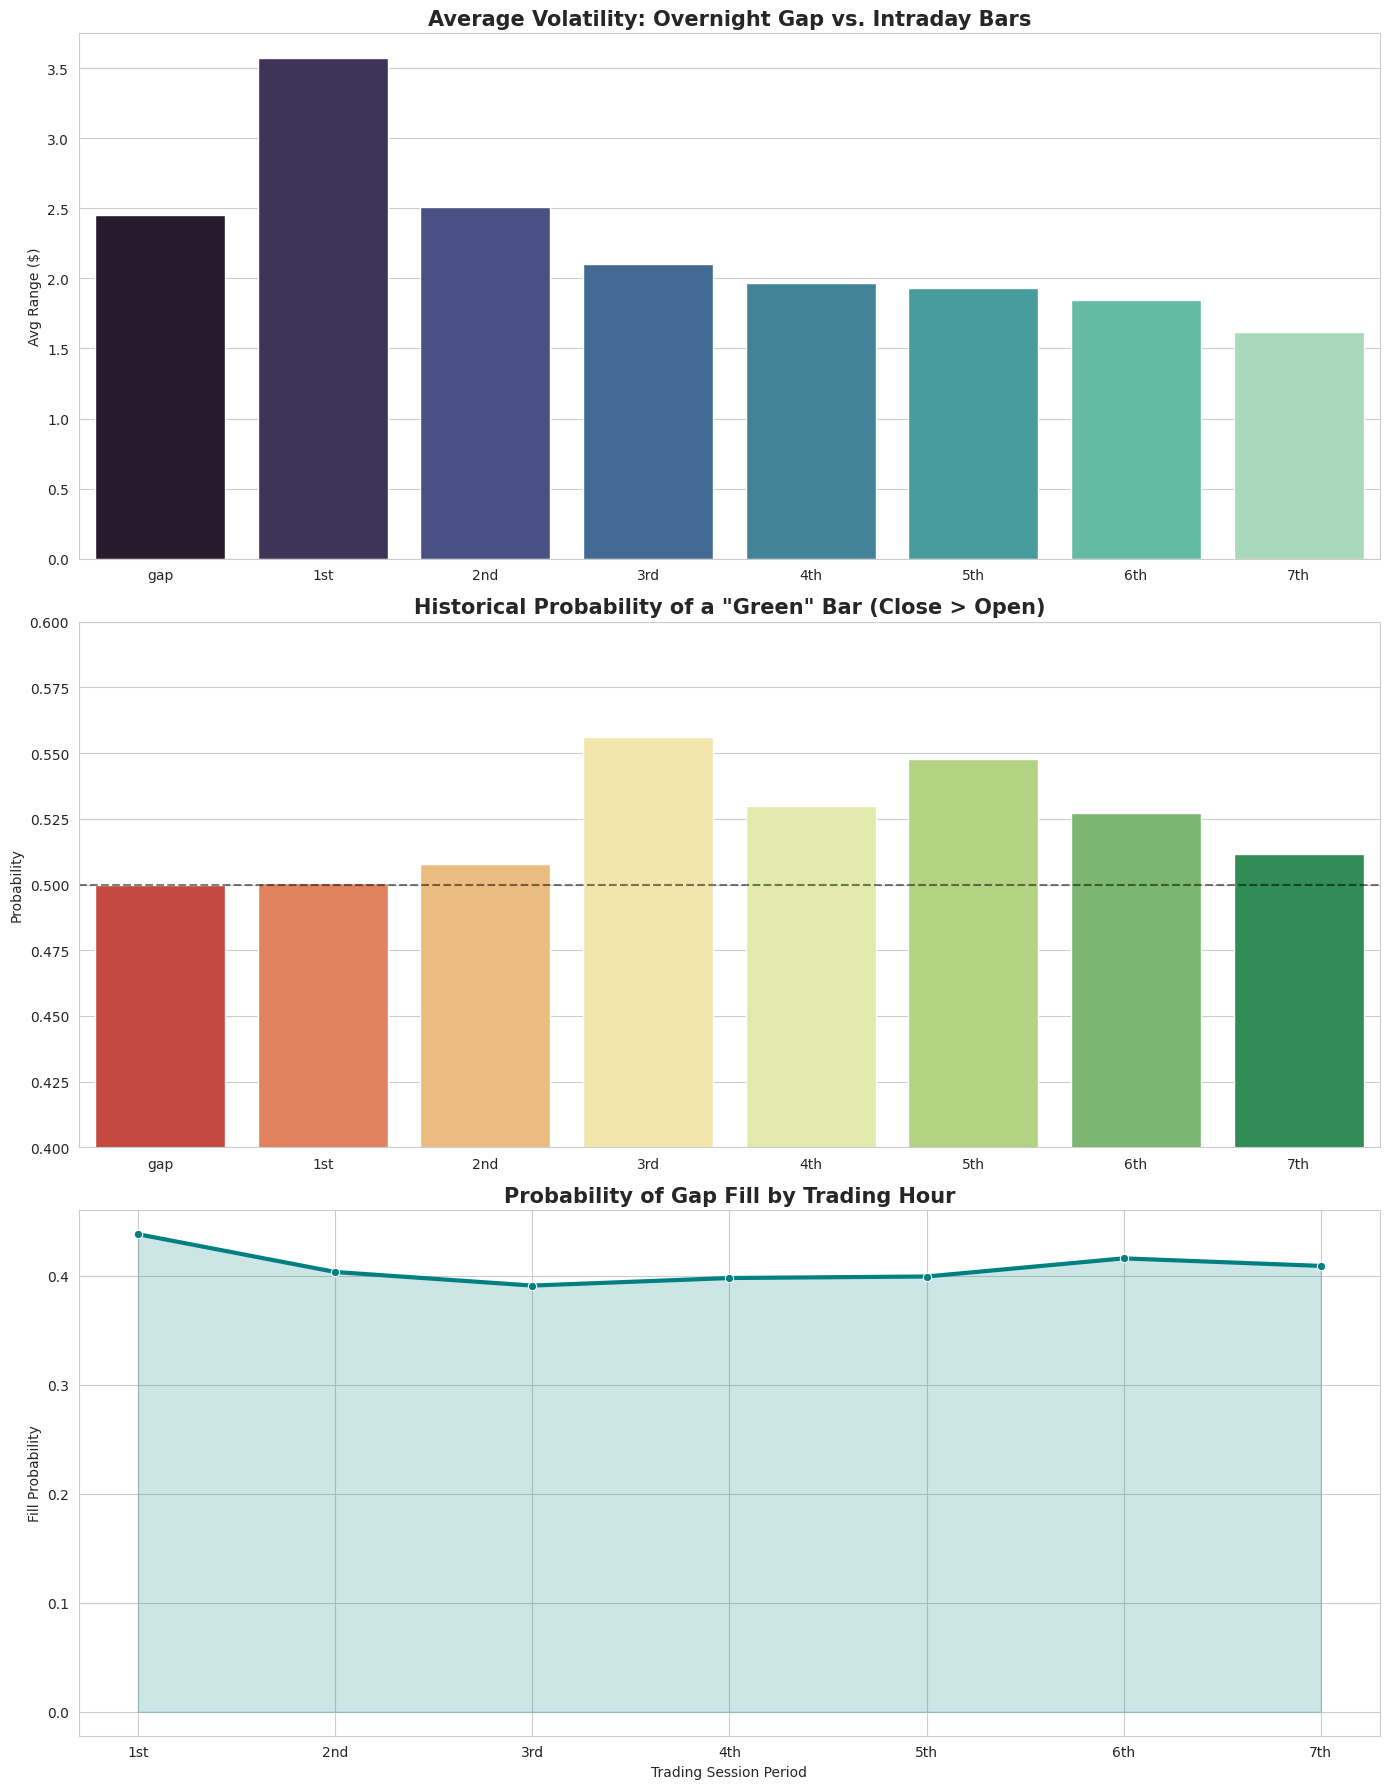

Total Days Analyzed: 721
Overall Gap Fill Probability: 60.89%


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Load and Clean Data
try:
    # Handle the multi-index header format often found in yfinance exports
    df = pd.read_csv('QQQ_1h.csv', header=[0, 1], index_col=0, parse_dates=True)
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
except:
    df = pd.read_csv('QQQ_1h.csv', index_col=0, parse_dates=True)

# Ensure numeric types and drop metadata rows
for col in ['Open', 'High', 'Low', 'Close']:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df = df.dropna(subset=['Open', 'High', 'Low', 'Close'])

# 2. Process Data by Trading Day
daily_groups = df.groupby(df.index.date)
processed_data = []

for date, group in daily_groups:
    group = group.sort_index()
    if len(group) < 5: continue # Skip partial days

    # Identify Previous Day's Close for the Gap
    prev_day_idx = df.index.get_loc(group.index[0]) - 1
    if prev_day_idx < 0: continue
    prev_close = df.iloc[prev_day_idx]['Close']

    # Calculate Overnight Gap
    opening_gap = group.iloc[0]['Open'] - prev_close

    # Store Period Data
    # Period 0 is the Gap. Periods 1-8 are the intraday bars.
    day_row = {'Date': date, 'Gap': opening_gap}

    for i in range(len(group)):
        label = f"Bar_{i+1}"
        day_row[f'{label}_Size'] = group.iloc[i]['High'] - group.iloc[i]['Low']
        day_row[f'{label}_Return'] = (group.iloc[i]['Close'] - group.iloc[i]['Open'])
        day_row[f'{label}_Is_Green'] = 1 if group.iloc[i]['Close'] > group.iloc[i]['Open'] else 0

        # Gap Fill Logic: Did the high/low of this bar touch the previous close?
        if opening_gap > 0: # Gap Up
            day_row[f'{label}_Filled'] = 1 if group.iloc[i]['Low'] <= prev_close else 0
        else: # Gap Down
            day_row[f'{label}_Filled'] = 1 if group.iloc[i]['High'] >= prev_close else 0

    processed_data.append(day_row)

stats_df = pd.DataFrame(processed_data)

# 3. Prepare Plotting Data with user's specific labels
labels = ['gap', '1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th (30m)']
# Note: yfinance 1h often gives 7 bars. If your data has 8, the code will map them.
num_bars = min(8, len([c for c in stats_df.columns if '_Size' in c]))
plot_labels = ['gap'] + [labels[i+1] for i in range(num_bars)]

# Calculate averages for the bars
avg_vol = [stats_df['Gap'].abs().mean()] + [stats_df[f'Bar_{i+1}_Size'].mean() for i in range(num_bars)]
win_rate = [0.5] + [stats_df[f'Bar_{i+1}_Is_Green'].mean() for i in range(num_bars)] # Gap doesn't have a "green" rate
fill_rate = [stats_df[f'Bar_{i+1}_Filled'].mean() for i in range(num_bars)]

# 4. Visualization
fig, axes = plt.subplots(3, 1, figsize=(14, 18))
sns.set_style("whitegrid")

# CHART 1: Volatility Profile (Bar Size)
sns.barplot(x=plot_labels, y=avg_vol, ax=axes[0], palette="mako")
axes[0].set_title('Average Volatility: Overnight Gap vs. Intraday Bars', fontsize=15, fontweight='bold')
axes[0].set_ylabel('Avg Range ($)')

# CHART 2: Growth Probability (Directional Bias)
sns.barplot(x=plot_labels, y=win_rate, ax=axes[1], palette="RdYlGn")
axes[1].axhline(0.5, color='black', linestyle='--', alpha=0.5)
axes[1].set_title('Historical Probability of a "Green" Bar (Close > Open)', fontsize=15, fontweight='bold')
axes[1].set_ylabel('Probability')
axes[1].set_ylim(0.4, 0.6)

# CHART 3: Gap Fill Probability (Crucial for Day Traders)
# Shows the % chance that the gap is filled during a specific hour
sns.lineplot(x=plot_labels[1:], y=fill_rate, ax=axes[2], marker='o', color='teal', linewidth=3)
axes[2].set_title('Probability of Gap Fill by Trading Hour', fontsize=15, fontweight='bold')
axes[2].set_ylabel('Fill Probability')
axes[2].set_xlabel('Trading Session Period')
axes[2].fill_between(plot_labels[1:], fill_rate, alpha=0.2, color='teal')

plt.tight_layout()
plt.show()

# Print Summary
print(f"Total Days Analyzed: {len(stats_df)}")
print(f"Overall Gap Fill Probability: {stats_df[[c for c in stats_df.columns if '_Filled' in c]].max(axis=1).mean():.2%}")